In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
import os
import copy
from torch import dropout, nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize


random.seed(42)


##### HYPERPARAMETERS

batch_size = 8 # documents

learning_rate = 7e-5 # sets AdamW optimizaiton learning rate
                     # scales scales with each training loop if scheduler is on

dropout_rate = 0.022 # sets same dropout for roberta and for classification layer

normalizer_before_class = False # toggle the normalizer before the classification layer
use_lr_scheduler = False  # toggle the linear learning rate scheduler

n_epochs = 8 # baseline probably minimizes after 4 Epochs'

##### end HPs

task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4, 'Unit':5}
num_classes = len(task_map)

# model_name = 'roberta-base'
# model_name = 'allenai/biomed_roberta_base'
model_name = 'allenai/cs_roberta_base'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

run_name = 'final_'+model_name.split('/')[-1] +'_bs-'+str(batch_size)+\
                                                '_lr-'+str(learning_rate)+\
                                                '_drop-'+str(dropout_rate)

print(run_name)

final_cs_roberta_base_bs-8_lr-7e-05_drop-0.022


In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

outputpath = os.path.join(currentdir, "../data/output/")

runoutpath = os.path.join(outputpath,run_name+'/')

In [3]:
runoutpath

'/home/sam/MeasEval/baselines/../data/output/final_cs_roberta_base_bs-8_lr-7e-05_drop-0.022/'

In [4]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [5]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = False)

In [6]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    idf_to_torch = lambda df : torch.tensor(np.array([list(map(int,r)) for r in df])).to(device)

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = idf_to_torch(tokenized_dataset['input_ids'].loc[start:end])
        attention_mask = idf_to_torch(tokenized_dataset['attention_mask'].loc[start:end])
        labels = idf_to_torch(tokenized_dataset['labels'].loc[start:end])
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [7]:
################# batchify ####################
stage1_train_ds = pd.read_pickle(interimpath+'stage1_train_ds.pickle')
batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)

stage1_test_ds = pd.read_pickle(interimpath+'stage1_test_ds.pickle')
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)


In [8]:
class Stage1model(nn.Module):
    def __init__(self, dropout=dropout_rate):
        super(Stage1model, self).__init__()
        self.mod = RobertaModel.from_pretrained(
                    model_name,
                    num_labels=num_classes+1,
                    hidden_dropout_prob=dropout,
                    output_hidden_states=True)
        if normalizer_before_class: 
            self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
        y_hat = output.hidden_states[-1]
        if normalizer_before_class: y_hat = self.norm(y_hat)
        y_hat = self.drop(y_hat)
        y_hat = self.classifier(y_hat).permute(0,2,1)
        return y_hat

model = Stage1model().to(device)

model_new = model


Some weights of the model checkpoint at allenai/cs_roberta_base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = AdamW(model.parameters(), lr=learning_rate)

n_training_steps = n_epochs * len(batched_train_ds)

if use_lr_scheduler:
    n_training_steps = n_epochs * len(batched_train_ds)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
    )


def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    loss_log = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        loss_log.append(loss.item())
        
        loss.backward()
        optimizer.step()
        if use_lr_scheduler: lr_scheduler.step()

        progress_bar.update(1)
            
    return loss_log



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    loss_log = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss_log.append(loss.item())

            for dlogits, dlabels in zip(logits.permute(0,2,1), labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss_log, acc, report, ytrue, ypred

In [10]:
run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_test_loss':[],
                'eval_test_acc':[],
                'eval_test_ytrue':[],
                'eval_test_ypred':[],
                'eval_test_rpt':[],
             }

num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_test_ds))
progress_bar = tqdm(range(num_total_steps))

for epoch in range(n_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(batched_train_ds, criterion)
    print(f"Last train batch loss: {loss[-1]}")
    run_report['train_loss'].extend(loss)
    
    output = eval_epoch(batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set bast batch loss: {loss[-1]}   accuracy: {acc}')
    run_report['eval_train_loss'].extend(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(batched_test_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on test set last batch loss: {loss[-1]}   accuracy: {acc}')
    run_report['eval_test_loss'].extend(loss)
    run_report['eval_test_acc'].append(acc)
    run_report['eval_test_ytrue'].append(ytrue)
    run_report['eval_test_ypred'].append(ypred)
    run_report['eval_test_rpt'].append(report)
    


  0%|          | 0/632 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Last train batch loss: 689.2225952148438
Eval on train set bast batch loss: 664.185546875   accuracy: 0.9447139616935484
Eval on test set last batch loss: 462.9878845214844   accuracy: 0.9457320601851852
============ Begin Epoch 2 ============
Last train batch loss: 386.0016174316406
Eval on train set bast batch loss: 347.4525451660156   accuracy: 0.9614494077620968
Eval on test set last batch loss: 361.3070068359375   accuracy: 0.9625
============ Begin Epoch 3 ============
Last train batch loss: 353.2839050292969
Eval on train set bast batch loss: 311.136474609375   accuracy: 0.9644263482862904
Eval on test set last batch loss: 359.43206787109375   accuracy: 0.9592013888888888
============ Begin Epoch 4 ============
Last train batch loss: 280.5665283203125
Eval on train set bast batch loss: 234.8363037109375   accuracy: 0.9741762222782258
Eval on test set last batch loss: 349.8904724121094   accuracy: 0.9623697916666667
============ Begin Epoch

['NoLabel', 'Quantity', 'MeasuredProperty', 'MeasuredEntity', 'Qualifier', 'Unit']
[[64740   138    48   107     7    40]
 [  102   979     8     5     0    25]
 [  332     8   206   150    11     8]
 [  614    11    27   547     0     7]
 [  349    14     4    59    17    14]
 [   25     3     6    23     0   486]]


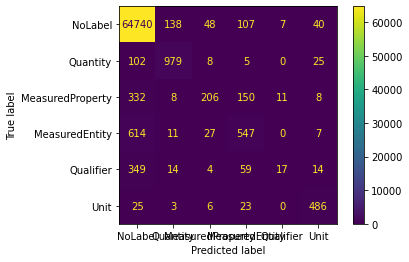

In [11]:
display_labels = list(task_map.keys())
display_labels.insert(0,str('NoLabel'))
print(display_labels)
cm = confusion_matrix(ytrue,ypred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels).plot()
plt.show()

In [12]:
with open(interimpath+'train_docs.json','r') as f:
    train_docs = json.load(f)

with open(interimpath+'test_docs.json','r') as f:
    test_docs = json.load(f)

ypred_by_doc = {}
ytrue_by_doc = {}
for i, doc in enumerate(test_docs):

    ypred_by_doc[doc] = ypred[i*512:(i+1)*512]
    ytrue_by_doc[doc] = ytrue[i*512:(i+1)*512]

    # print(f'aligned {len(ypred_by_doc[doc])} predictions into doc {doc}')

#### Test doc-to-label alignment
for test_doc in test_docs:
    input_lab = stage1_test_ds.loc[stage1_test_ds['doc_or_sent_id']==test_doc]['labels']
    assert ytrue_by_doc[test_doc] == list(input_lab.values[0])

In [13]:
def tabulate_metrics(reports):
    metrics = []
    for epoch in reports:
        # print(epoch)
        epoch_metrics = {}
        for task, rpt in task_map.items():
            # print(task)
            for metric, value in epoch[task].items():
                epoch_metrics[str(task+'_'+metric)] = value
        epoch_metrics['wt_f1'] = epoch['weighted avg']['f1-score']
        metrics.append(epoch_metrics)

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.index.rename('epoch')
    return metrics
train_set_metrics = tabulate_metrics(run_report['eval_train_rpt'])
train_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,...,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support,Unit_precision,Unit_recall,Unit_f1-score,Unit_support,wt_f1
0,0.852645,0.309982,0.454668,2184,0.000000,0.000000,0.000000,1316,0.000000,0.000000,...,2431,0.000000,0.000000,0.000000,746,0.000000,0.000000,0.000000,925,0.130623
1,0.867447,0.847985,0.857606,2184,0.504505,0.042553,0.078486,1316,0.482968,0.163307,...,2431,0.000000,0.000000,0.000000,746,0.835979,0.854054,0.844920,925,0.440833
2,0.861611,0.920788,0.890217,2184,0.334191,0.789514,0.469605,1316,0.477038,0.418758,...,2431,0.000000,0.000000,0.000000,746,0.839167,0.958919,0.895055,925,0.588581
3,0.884929,0.943681,0.913361,2184,0.433320,0.851824,0.574430,1316,0.623705,0.619087,...,2431,0.794118,0.036193,0.069231,746,0.859330,0.970811,0.911675,925,0.678278
4,0.917254,0.954212,0.935368,2184,0.520760,0.895897,0.658659,1316,0.755328,0.787330,...,2431,0.859375,0.073727,0.135802,746,0.878641,0.978378,0.925831,925,0.755280
5,0.940647,0.957875,0.949183,2184,0.684544,0.901976,0.778361,1316,0.836519,0.846154,...,2431,0.907473,0.341823,0.496592,746,0.924720,0.982703,0.952830,925,0.841145
6,0.969767,0.954670,0.962160,2184,0.754976,0.835866,0.793365,1316,0.737235,0.974085,...,2431,0.980000,0.262735,0.414376,746,0.940377,0.971892,0.955875,925,0.839121
7,0.981378,0.965201,0.973223,2184,0.934034,0.742401,0.827265,1316,0.871662,0.832579,...,2431,0.979943,0.458445,0.624658,746,0.947368,0.992432,0.969377,925,0.874412


In [14]:
test_set_metrics = tabulate_metrics(run_report['eval_test_rpt'])
test_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,...,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support,Unit_precision,Unit_recall,Unit_f1-score,Unit_support,wt_f1
0,0.872973,0.288651,0.433848,1119,0.000000,0.000000,0.000000,715,0.000000,0.000000,...,1206,0.000000,0.000000,0.000000,457,0.000000,0.000000,0.000000,543,0.120167
1,0.867036,0.839142,0.852861,1119,0.627119,0.051748,0.095607,715,0.532663,0.175788,...,1206,0.000000,0.000000,0.000000,457,0.829670,0.834254,0.831956,543,0.443875
2,0.819592,0.897230,0.856655,1119,0.309751,0.679720,0.425569,715,0.374766,0.332504,...,1206,0.000000,0.000000,0.000000,457,0.816260,0.924494,0.867012,543,0.534314
3,0.822041,0.899911,0.859215,1119,0.365079,0.643357,0.465823,715,0.429498,0.439469,...,1206,0.250000,0.006565,0.012793,457,0.819376,0.918969,0.866319,543,0.567995
4,0.824896,0.888293,0.855422,1119,0.420054,0.650350,0.510428,715,0.499633,0.564677,...,1206,0.250000,0.006565,0.012793,457,0.821018,0.920810,0.868056,543,0.603652
5,0.821044,0.885612,0.852107,1119,0.481439,0.580420,0.526316,715,0.593560,0.565506,...,1206,0.444444,0.043764,0.079681,457,0.829642,0.896869,0.861947,543,0.626926
6,0.828498,0.867739,0.847665,1119,0.533557,0.444755,0.485126,715,0.464343,0.718076,...,1206,0.555556,0.010941,0.021459,457,0.838313,0.878453,0.857914,543,0.606738
7,0.849089,0.874888,0.861796,1119,0.688963,0.288112,0.406312,715,0.613917,0.453566,...,1206,0.485714,0.037199,0.069106,457,0.837931,0.895028,0.865539,543,0.590495


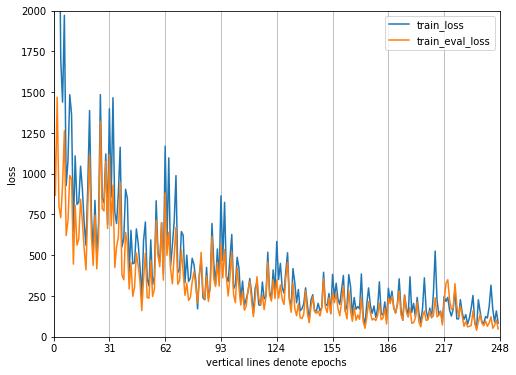

In [15]:
########################## loss plot #######################

n_batches = len(batched_train_ds)
n_epochs = len(run_report['epoch'])
n_steps = n_epochs*n_batches
steps = np.array(range(n_steps))
train_loss = np.array(run_report['train_loss'])
train_eval_loss = np.array(run_report['eval_train_loss'])

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
tics = plticker.MultipleLocator(n_batches)
ax.xaxis.set_major_locator(tics)
ax.set_xlim(0,n_steps)
ax.set_ylim(0,2000)
ax.plot(steps,train_loss,label='train_loss')
ax.plot(steps,train_eval_loss,label='train_eval_loss')

plt.grid(axis='x')
plt.legend()
plt.ylabel('loss')
plt.xlabel('vertical lines denote epochs')
plt.show()

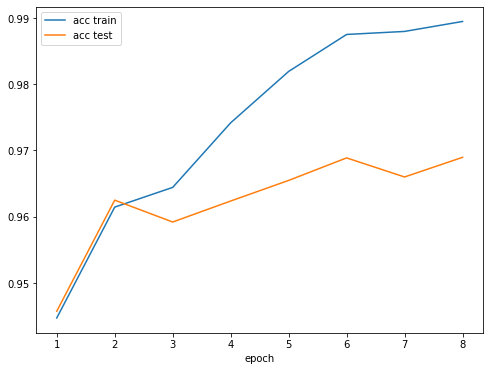

In [16]:
########################## test set accuracy plot #######################

epoch = np.array(range(len(run_report['epoch'])))
ytrain = np.array(run_report['eval_train_acc'])
ytest = np.array(run_report['eval_test_acc'])


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(epoch+1,ytrain, label='acc train')
ax.plot(epoch+1,ytest, label='acc test')
plt.legend()
plt.xlabel('epoch')
plt.show()

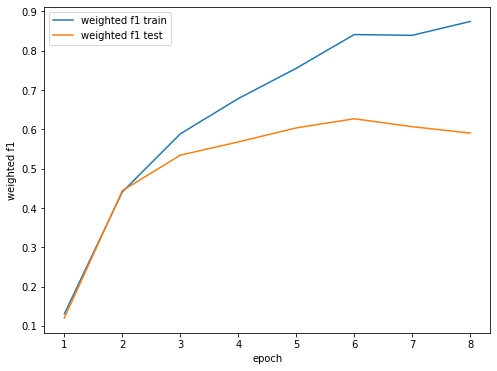

In [17]:
########################## weighted f1 plot #######################

epoch = np.array(range(len(run_report['epoch'])))
ytrain = np.array(train_set_metrics['wt_f1'])
ydev = np.array(test_set_metrics['wt_f1'])


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(epoch+1,ytrain, label='weighted f1 train')
ax.plot(epoch+1,ydev, label='weighted f1 test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('weighted f1')
plt.show()

In [18]:
try: os.makedirs(runoutpath)
except: pass

with open(runoutpath+'ypred.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(runoutpath+'ytrue.json','w') as f:
    json.dump(ytrue_by_doc, f)

with open(runoutpath+'ypred_by_doc.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(runoutpath+'ytrue_by_doc.json','w') as f:
    json.dump(ytrue_by_doc, f)

test_set_metrics.to_csv(runoutpath+'test_set_metrics')

train_set_metrics.to_csv(runoutpath+'train_set_metrics')

: 